# Анализ оттока клиентов

Перед нами стоит задача проанализировать клиентов регионального банка «Метанпром» и выделить портрет клиентов, которые склонны уходить из банка.

#### Описание датасета

Датасет содержит данные о клиентах банка «Метанпром». Банк располагается в Ярославле и областных городах: Ростов Великий и Рыбинск.

Колонки:

- `userid` — идентификатор пользователя,
- `score` — баллы кредитного скоринга,
- `City` — город,
- `Gender` — пол,
- `Age` — возраст,
- `Objects` — количество объектов в собственности,
- `Balance` — баланс на счёте,
- `Products` — количество продуктов, которыми пользуется клиент,
- `CreditCard` — есть ли кредитная карта,
- `Loyalty` — активный клиент,
- `estimated_salary` — заработная плата клиента,
- `Churn` — ушёл или нет.

### Шаг 1. Загрузим и проведем первичный осмотр данных.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

In [2]:
df = pd.read_csv('/datasets/bank_dataset.csv')

In [3]:
df.head()

,userid,score,City,Gender,Age,Objects,Balance,Products,CreditCard,Loyalty,estimated_salary,Churn
0,15677338,619,Ярославль,Ж,42,2,NaN,1,1,1,101348.88,1
1,15690047,608,Рыбинск,Ж,41,1,83807.86,1,0,1,112542.58,0
2,15662040,502,Ярославль,Ж,42,8,159660.80,3,1,0,113931.57,1
3,15744090,699,Ярославль,Ж,39,1,NaN,2,0,0,93826.63,0
4,15780624,850,Рыбинск,Ж,43,2,125510.82,1,1,1,79084.10,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
userid              10000 non-null int64
score               10000 non-null int64
City                10000 non-null object
Gender              10000 non-null object
Age                 10000 non-null int64
Objects             10000 non-null int64
Balance             6383 non-null float64
Products            10000 non-null int64
CreditCard          10000 non-null int64
Loyalty             10000 non-null int64
estimated_salary    10000 non-null float64
Churn               10000 non-null int64
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


In [5]:
df.shape

(10000, 12)

In [6]:
df.columns

Index(['userid', 'score', 'City', 'Gender', 'Age', 'Objects', 'Balance',
       'Products', 'CreditCard', 'Loyalty', 'estimated_salary', 'Churn'],
      dtype='object')

In [7]:
df.duplicated().sum()

0

In [8]:
df['userid'].nunique()

10000

In [9]:
df.isnull().sum()

userid                 0
score                  0
City                   0
Gender                 0
Age                    0
Objects                0
Balance             3617
Products               0
CreditCard             0
Loyalty                0
estimated_salary       0
Churn                  0
dtype: int64

**Вывод:** Импортировали дасет, состящий из 10000 уникальных строк и 12 столбцов. Баланс и заработная плата имеют тип float, разный регистр в названиях столбцов, дубликаты отсутствуют, имеются пропуски в столбце баланса.

### Шаг. 2  Проведение исследовательского анализа данных (EDA)

#### Предобработка данных:

- Приведем к нижнему регистру названия столбцов.

In [10]:
df.set_axis(df.columns.str.lower(), axis='columns', inplace=True)

In [11]:
df.columns

Index(['userid', 'score', 'city', 'gender', 'age', 'objects', 'balance',
       'products', 'creditcard', 'loyalty', 'estimated_salary', 'churn'],
      dtype='object')

- Замена пропусков

В стоблце Баланс у нас имеет 36% пропущенных значений, для решения поиска данных необходимо обратиться к администратору базы. Поскольку у нас нет такой возможности, а под NaN может быть как любое число так и не заполненные данные. В связи с этим, принято решение оставить данные как есть.

 - Приведем данные в целочисленный формат.

In [12]:
df['estimated_salary'] = df['estimated_salary'].astype('int')

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
userid              10000 non-null int64
score               10000 non-null int64
city                10000 non-null object
gender              10000 non-null object
age                 10000 non-null int64
objects             10000 non-null int64
balance             6383 non-null float64
products            10000 non-null int64
creditcard          10000 non-null int64
loyalty             10000 non-null int64
estimated_salary    10000 non-null int64
churn               10000 non-null int64
dtypes: float64(1), int64(9), object(2)
memory usage: 937.6+ KB


**Вывод:** Привели названия столбцов к нижнему регистру, пропуски в стобце баланса, оставили без изменений(необходимо обратиться к администратору базы данных), данные в столбце заработная плата перевели в целочисленный формат. 

#### Изучим средние значения

In [14]:
df.describe()

,userid,score,age,objects,balance,products,creditcard,loyalty,estimated_salary,churn
count,1.000000e+04,10000.000000,10000.000000,10000.000000,6383.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,1.573368e+07,650.528800,38.921800,5.012800,119827.493793,1.530200,0.70550,0.515100,100089.748400,0.203700
std,7.193619e+04,96.653299,10.487806,2.892174,30095.056462,0.581654,0.45584,0.499797,57510.491042,0.402769
min,1.560844e+07,350.000000,18.000000,0.000000,3768.690000,1.000000,0.00000,0.000000,11.000000,0.000000
25%,1.567126e+07,584.000000,32.000000,3.000000,100181.975000,1.000000,0.00000,0.000000,51001.750000,0.000000
50%,1.573347e+07,652.000000,37.000000,5.000000,119839.690000,1.000000,1.00000,1.000000,100193.500000,0.000000
75%,1.579597e+07,718.000000,44.000000,7.000000,139512.290000,2.000000,1.00000,1.000000,149387.750000,0.000000
max,1.585843e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.000000,1.000000


**Вывод:** Портрет среднестатистического клиента: средний кредитный рейтинг 650, средний возраст 39 лет со средней заработной платой 100000 и балансом на счету 120000. Доля ушедших клиентов равняется 20,37 %. 

Посмотрим работников с зарплатой 11 рублей, отсортируем таблицу по столбцу зараборной платы.

In [15]:
df.sort_values(by='estimated_salary').head()

,userid,score,city,gender,age,objects,balance,products,creditcard,loyalty,estimated_salary,churn
2362,15833789,709,Ростов Великий,М,45,4,122917.71,1,1,1,11,1
9647,15722429,625,Ярославль,М,31,5,NaN,2,0,1,90,0
9010,15829199,645,Ростов Великий,Ж,59,8,121669.93,2,0,0,91,1
5548,15682398,710,Ярославль,М,38,2,NaN,2,1,0,96,0
4989,15645587,629,Ярославль,М,40,9,NaN,1,1,0,106,0


Следует предположить, что строка зарабоная плата это ни как таковая заработная, а поступления различных средств с разных источников на счета клиентов, возможно даже переводы самому себе с другого банка, а также остатки.  

Посмотрим средние значения данных у оставшихся и ушедших.

In [16]:
df_leave_stay = df.groupby('churn').mean()
df_leave_stay = df_leave_stay.drop(columns = 'userid')

In [17]:
df_leave_stay.T.style.format('{:,.2f}').set_caption('Средние значения признаков по группам, тех кто ушел 1, тех кто остался 0')

churn,0,1
score,651.85,645.35
age,37.41,44.84
objects,5.03,4.93
balance,"119,535.86","120,746.97"
products,1.54,1.48
creditcard,0.71,0.70
loyalty,0.55,0.36
estimated_salary,"99,737.90","101,465.18"


**Вывод:** Критических измений средних значений не наблюдаем, в основном все значения имеют небольшое отличие, наиболее отличны возраст: уходят примерно 45 летние наименее активные клиенты, а остаются 37 летние и активные клиенты.

#### Посчитаем количество оставшихся и ушедших клиентов

In [18]:
df.churn.value_counts()

0    7963
1    2037
Name: churn, dtype: int64

**Вывод:** Количество оставшихся клиентов **7963**, количество ушедших **2037**.

#### Сколько клиентов в каких городах проживает?

In [19]:
df['city'].value_counts()

Ярославль         5014
Ростов Великий    2509
Рыбинск           2477
Name: city, dtype: int64

**Вывод:** В Ярославле больше всего клиентов, в Ростове великом и Рыбинке почти сопоставимы.

#### Построим столбчатые диаграммы для тех кто ушел и тех кто остался

Напишем функцию для рассчета данных и построения гистограмм. Для начала категоризуем данные по баллам кредитного скоринга, возрасту, балансу и заработной плате, воспользуемся квантилями.

In [20]:
# выберем квантили
df['score'].quantile([0.25,0.5,0.75])  

0.25    584.0
0.50    652.0
0.75    718.0
Name: score, dtype: float64

In [21]:
# напишем функцию для перебора и присвоения соответствуещего значения в новом столбце, который добавляем в таблицу
def score_level(score):
    if score <= 584:
        return 'по 584'
    if score <= 652:
        return 'по 652'
    if score <= 718:
        return 'по 718'
    return 'выше 719'
print(score_level(525))
df['score_level'] = df['score'].apply(score_level)   
print(df['score_level'].value_counts()) 

по 584
по 584      2534
по 718      2502
по 652      2501
выше 719    2463
Name: score_level, dtype: int64


In [22]:
df['age'].quantile([0.25,0.5,0.75])

0.25    32.0
0.50    37.0
0.75    44.0
Name: age, dtype: float64

In [23]:
def age_level(age):
    if age <= 32:
        return 'по 32'
    if age <= 37:
        return 'по 37'
    if age <= 44:
        return 'по 44'
    return 'выше 45'
print(age_level(52))
df['age_level'] = df['age'].apply(age_level)   
print(df['age_level'].value_counts()) 

выше 45
по 32      2790
по 44      2573
выше 45    2340
по 37      2297
Name: age_level, dtype: int64


In [24]:
df['balance'].quantile([0.25,0.5,0.75])

0.25    100181.975
0.50    119839.690
0.75    139512.290
Name: balance, dtype: float64

In [25]:
def balance_level(balance):
    if balance <= 100182:
        return 'по 100182'
    if balance <= 119840:
        return 'по 119840'
    if balance <= 139512:
        return 'по 139512'
    return 'выше 139513'
print(balance_level(52))
df['balance_level'] = df['balance'].apply(balance_level)   
print(df['balance_level'].value_counts())

по 100182
выше 139513    5213
по 119840      1596
по 100182      1596
по 139512      1595
Name: balance_level, dtype: int64


In [26]:
df['estimated_salary'].quantile([0.25,0.5,0.75])

0.25     51001.75
0.50    100193.50
0.75    149387.75
Name: estimated_salary, dtype: float64

In [27]:
def salary_level(estimated_salary):
    if estimated_salary <= 51002:
        return 'по 51002'
    if estimated_salary <= 100194:
        return 'по 100194'
    if estimated_salary <= 149388:
        return 'по 149388'
    return 'выше 149389'
print(salary_level(105352))
df['salary_level'] = df['estimated_salary'].apply(salary_level)   
print(df['salary_level'].value_counts())

по 149388
по 100194      2500
по 149388      2500
выше 149389    2500
по 51002       2500
Name: salary_level, dtype: int64


In [28]:
df.head()

,userid,score,city,gender,age,objects,balance,products,creditcard,loyalty,estimated_salary,churn,score_level,age_level,balance_level,salary_level
0,15677338,619,Ярославль,Ж,42,2,NaN,1,1,1,101348,1,по 652,по 44,выше 139513,по 149388
1,15690047,608,Рыбинск,Ж,41,1,83807.86,1,0,1,112542,0,по 652,по 44,по 100182,по 149388
2,15662040,502,Ярославль,Ж,42,8,159660.80,3,1,0,113931,1,по 584,по 44,выше 139513,по 149388
3,15744090,699,Ярославль,Ж,39,1,NaN,2,0,0,93826,0,по 718,по 44,выше 139513,по 100194
4,15780624,850,Рыбинск,Ж,43,2,125510.82,1,1,1,79084,0,выше 719,по 44,по 139512,по 100194


Данные категоризированны, продолжаем изучение.

##### Есть ли зависимость между городом и уходом клиента?

In [29]:
# выберим необходимые колонки для анализа
columns = ['city', 'gender', 'age_level', 'objects', 'balance_level', 'products',
       'creditcard', 'loyalty', 'salary_level']
#напишем функцию для расчета количества клиентов и построения графика. 
def fig(name):
    name = df.pivot_table(index = name, columns = 'churn', values = 'userid', aggfunc = 'count')
    name.columns = ['stay', 'leave']
    name['all'] = name['leave'] + name['stay']
    name['%'] = ((name['leave'] / name['stay'])*100).round(1)
    print(name.reset_index())
    name.plot(kind='bar', y = ["stay", "leave"],  legend=True, figsize = (10, 5), rot = 0)
    plt.title('Оставшиеся и ушедшие клиенты', color = "grey")
    plt.ylabel('Количество клиентов');

             city  stay  leave   all     %
0  Ростов Великий  1695    814  2509  48.0
1         Рыбинск  2064    413  2477  20.0
2       Ярославль  4204    810  5014  19.3


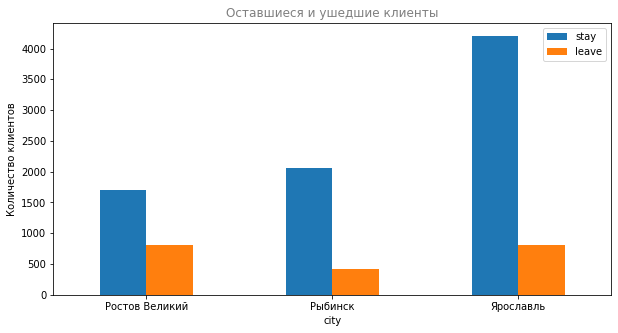

In [30]:
fig('city')

Наибольшее количество ушедших клиентов в городе Ростов Великий 48%! это почти половина всех клиентов, причины могут быть разные, как связанные с закрытием филиала или с уходом крупных компаний с зарплатными проектами, а также с приходом в город банков конкурентов с более выгодными предложениями. В Рыбинске и Ярославле оттоки сопоставимы на уровне примерно 20%. 

##### Есть ли зависимость между полом и уходом клиента?

  gender  stay  leave   all     %
0      Ж  3404   1139  4543  33.5
1      М  4559    898  5457  19.7


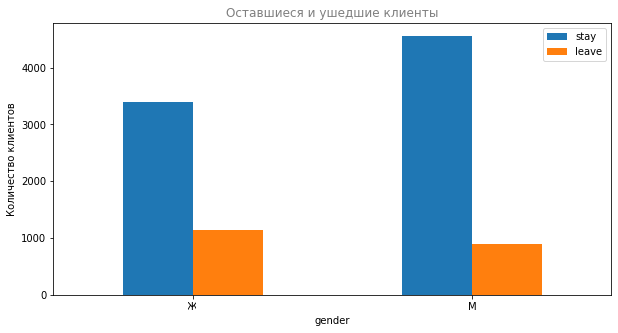

In [31]:
fig('gender')

Женщины наиболее стремительно покидают банк в отличии от мужчин 33,5% и 19,7% соответственно, вероятно это связано с их характером. 

##### Есть ли зависимость между возрастом и уходом клиента?

  age_level  stay  leave   all     %
0   выше 45  1296   1044  2340  80.6
1     по 32  2577    213  2790   8.3
2     по 37  2048    249  2297  12.2
3     по 44  2042    531  2573  26.0


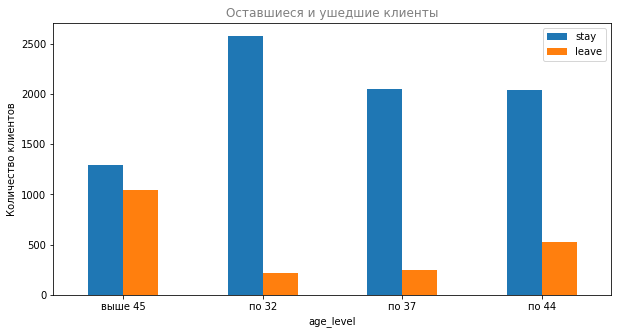

In [32]:
fig('age_level')

Наблюдается критичный отток клиентов свыше 45 лет - 80,6%, наименьший отток у молодежи возрастом до 32 лет - 8,3%. 

##### Есть ли зависимость между количеством объектов и уходом клиента?

    objects  stay  leave   all     %
0         0   318     95   413  29.9
1         1   803    232  1035  28.9
2         2   847    201  1048  23.7
3         3   796    213  1009  26.8
4         4   786    203   989  25.8
5         5   803    209  1012  26.0
6         6   771    196   967  25.4
7         7   851    177  1028  20.8
8         8   828    197  1025  23.8
9         9   771    213   984  27.6
10       10   389    101   490  26.0


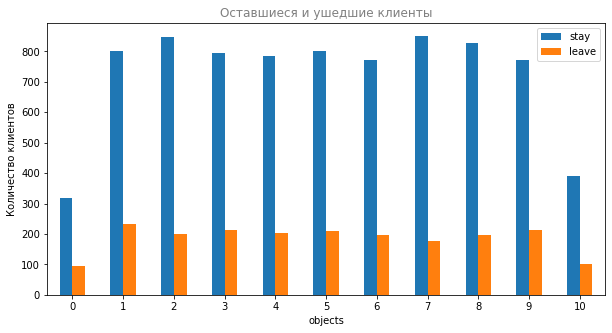

In [33]:
fig('objects')

Четкой зависимости не наблюдается, в разброс от 20% до 30%.

##### Есть ли зависимость между балансом на счете и уходом клиента?

  balance_level  stay  leave   all     %
0   выше 139513  4346    867  5213  19.9
1     по 100182  1267    329  1596  26.0
2     по 119840  1159    437  1596  37.7
3     по 139512  1191    404  1595  33.9


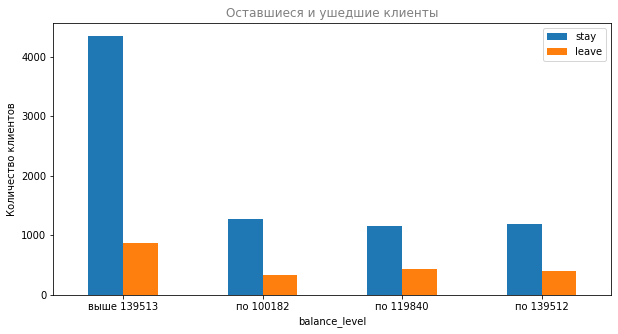

In [34]:
fig('balance_level')

Клиенты с балансом счета от 100182 - 119840 имеют наибольший отток 37,7% , на втором месте клиенты с балансом 119840 -139512 имеют отток 33,9% наименьший отток у клиентов со счетом выше 139513 - 19,9%. 

##### Есть ли зависимость между количеством продуктов и уходом клиента?

   products    stay   leave     all      %
0         1  3675.0  1409.0  5084.0   38.3
1         2  4242.0   348.0  4590.0    8.2
2         3    46.0   220.0   266.0  478.3
3         4     NaN    60.0     NaN    NaN


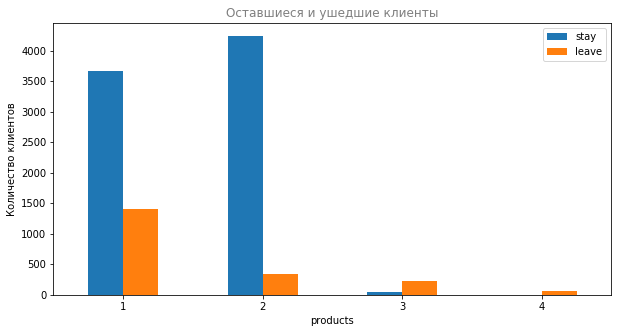

In [35]:
fig('products')

Самый космически лидирующий отток у клиентов, которые пользуются 3 продуктами компании **478,3%**, по 4 продукта никто из оставшихся не пользуется, а всего их было 60 человек, хотелось бы узнать что это были за такие "бомбические" продукты. Наименьший отток у клиентов, использующих два продукта банка и составляет 8,2%.

##### Есть ли зависимость между наличием кредитной карты и уходом клиента?

   creditcard  stay  leave   all     %
0           0  2332    613  2945  26.3
1           1  5631   1424  7055  25.3


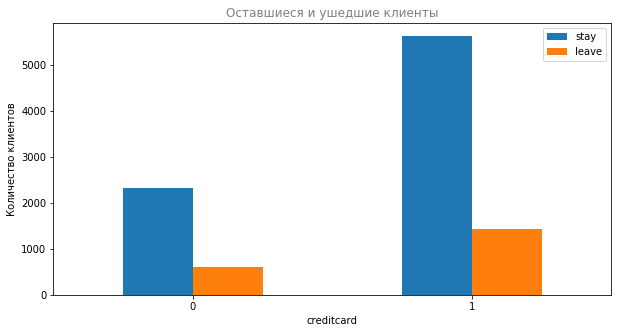

In [36]:
fig('creditcard')

Явных различий между клиентами имеющих кредитную карту и нет, не имеется разница составляет порядка 25-26%. 

##### Есть ли зависимость между активностью клиента и уходом клиента?

   loyalty  stay  leave   all     %
0        0  3547   1302  4849  36.7
1        1  4416    735  5151  16.6


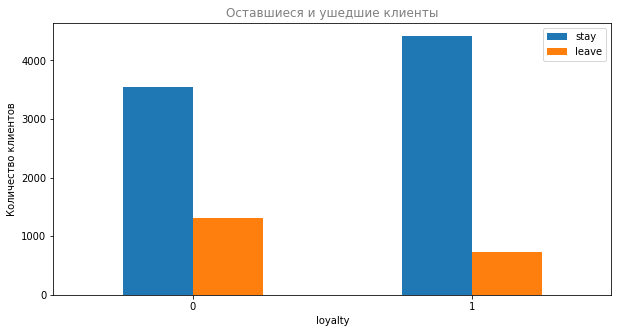

In [37]:
fig('loyalty')

Отток у не активных клиентов больше и составляет 36,7% , активные клиенты меньше уходят из банка 16,6%.

##### Есть ли зависимость уровнем заработной платы и уходом клиента?

  salary_level  stay  leave   all     %
0  выше 149389  1961    539  2500  27.5
1    по 100194  2005    495  2500  24.7
2    по 149388  1997    503  2500  25.2
3     по 51002  2000    500  2500  25.0


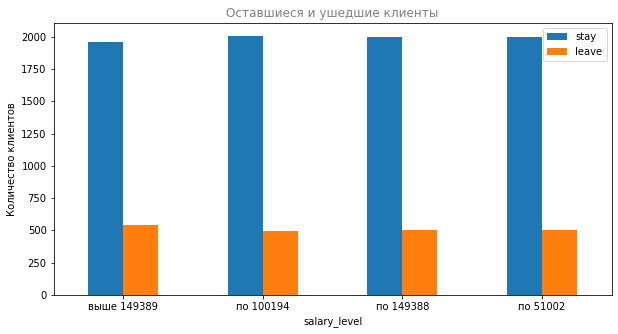

In [38]:
fig('salary_level')

Датасет поделен божественно, никого не обидели. Явной зависимости оттока клиентов не наблюдается, но чуть больше отток происходит у клиентов с зарплатой выше 149389 - 27,5%

### Шаг 3. Сформулировать и проверить статистические гипотезы

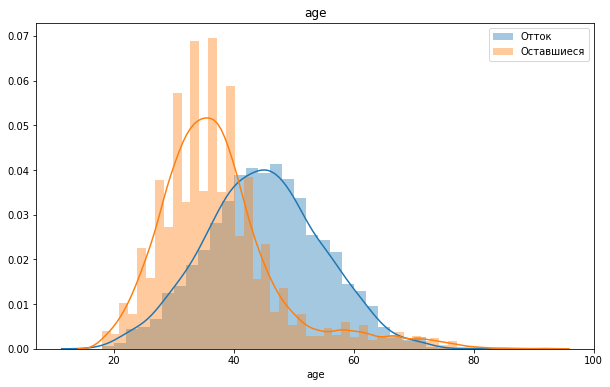

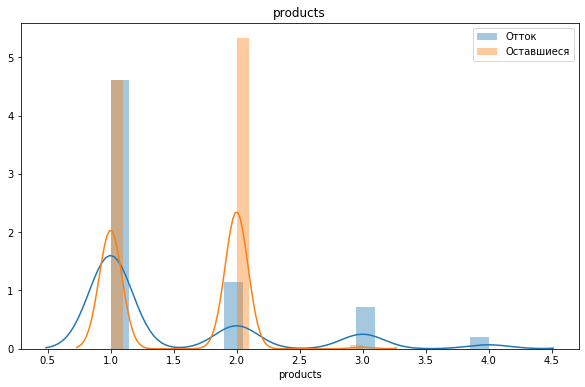

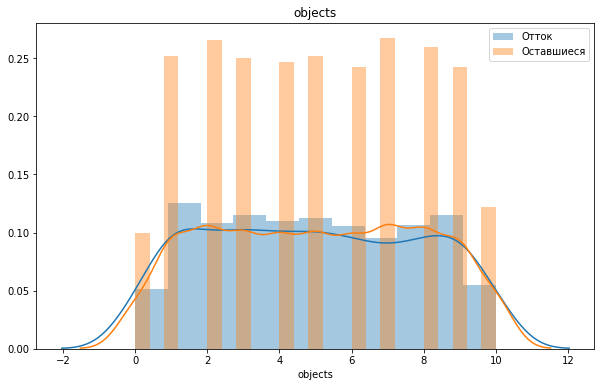

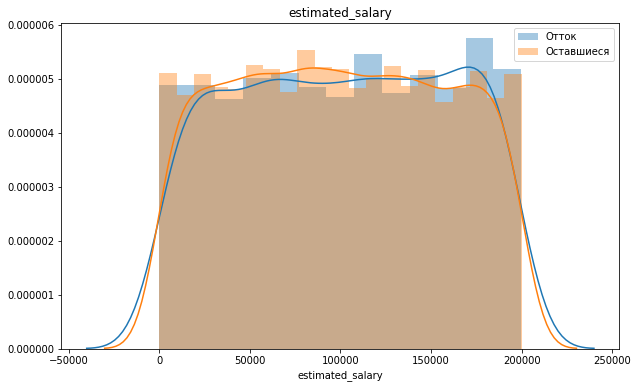

In [39]:
# посмотрим на распределения создадим таблицы по клиентам и список необходимых столбцов
leave = df[df['churn'] == 1]
stay = df[df['churn'] == 0]
distplot_columns = ['age', 'products', 'objects', 'estimated_salary']
# напишем цикл для отрисовки графиков
for column in distplot_columns: 
    plt.figure(figsize=(10,6)) 
    plt.title(column)
    sns.distplot(leave[column])
    sns.distplot(stay[column])
    plt.legend(['Отток', 'Оставшиеся'])
    plt.show()

#### Гипотеза:  различия дохода между теми клиентами, которые ушли и теми, которые остались

Поскольку выборки не имеют нормального распределения, воспользуемся  непараметрическим критерием статистической значимости U-критерий Манна-Уитни, сделаем двустороннюю проверку гипотез.  

Нулевая гипотеза: различий дохода между теми клиентами, которые ушли и теми, которые остались нет

Альтернативная гипотеза: между теми клиентами, которые ушли и теми, которые остались есть значимая разница дохода.

In [40]:
#выделим данные для проведения теста
salary_0 = df[df['churn'] == 0][['estimated_salary']]
salary_1 = df[df['churn'] == 1][['estimated_salary']]

In [41]:
# проведем тест, выберим значение alpha = 0.05
stat,p = stats.mannwhitneyu(salary_0, salary_1, alternative = 'two-sided')
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Не удается отклонить нулевую гипотезу')
else:
    print('Отклоняем нулевую гипотезу')

Statistics=7969862.000, p=0.227
Не удается отклонить нулевую гипотезу


Из полученных данных можно сделать вывод, что различий дохода между теми клиентами, которые ушли и которые остались нет.

#### Гипотеза:  различия возраста между теми клиентами, которые ушли и теми, которые остались

Поскольку распределение нормальное, то воспользуемся параметрическим тестом Стьюдента.

Нулевая гипотеза: различий возраст между теми клиентами, которые ушли и теми, которые остались нет

Альтернативная гипотеза: между теми клиентами, которые ушли и теми, которые остались есть значимая разница возраста.

In [42]:
age_0 = df[df['churn'] == 0][['age']]
age_1 = df[df['churn'] == 1][['age']]

In [43]:
stat, p = stats.ttest_ind(age_0, age_1)
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Не удается отклонить нулевую гипотезу')
else:
    print('Отклоняем нулевую гипотезу')

Statistics=-29.767, p=0.000
Отклоняем нулевую гипотезу


Значимая разница различия возраста между ушедшими и оставшимися клиентами есть. 

#### Гипотеза:  различия количества продуктов между теми клиентами, которые ушли и теми, которые остались

Поскольку выборки не имеют нормального распределения, воспользуемся  непараметрическим критерием статистической значимости U-критерий Манна-Уитни, сделаем двустороннюю проверку гипотез.  

Нулевая гипотеза: различий по количеству продуктов между теми клиентами, которые ушли и теми, которые остались нет

Альтернативная гипотеза: между теми клиентами, которые ушли и теми, которые остались есть значимая разница по количеству продуктов.

In [44]:
products_0 = df[df['churn'] == 0][['products']]
products_1 = df[df['churn'] == 1][['products']]

In [45]:
stat,p = stats.mannwhitneyu(products_0, products_1, alternative = 'two-sided')
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Не удается отклонить нулевую гипотезу')
else:
    print('Отклоняем нулевую гипотезу')

Statistics=9390005.500, p=0.000
Отклоняем нулевую гипотезу


Значимая разница различий по количеству продуков банка между ушедшими и оставшимися клиентами есть. 

#### Гипотеза:  различия количества объектов между теми клиентами, которые ушли и теми, которые остались

Поскольку выборки не имеют нормального распределения, воспользуемся  непараметрическим критерием статистической значимости U-критерий Манна-Уитни, сделаем двустороннюю проверку гипотез.  

Нулевая гипотеза: различий по количеству объектов между теми клиентами, которые ушли и теми, которые остались нет

Альтернативная гипотеза: между теми клиентами, которые ушли и теми, которые остались есть значимая разница по количеству объектов.

In [46]:
objects_0 = df[df['churn'] == 0][['objects']]
objects_1 = df[df['churn'] == 1][['objects']]

In [47]:
stat,p = stats.mannwhitneyu(objects_0, objects_1, alternative = 'two-sided')
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Не удается отклонить нулевую гипотезу')
else:
    print('Отклоняем нулевую гипотезу')

Statistics=8272055.500, p=0.162
Не удается отклонить нулевую гипотезу


Из полученных данных можно сделать вывод, что различий по количеству объектов в собственности между теми клиентами, которые ушли и которые остались нет.

### Шаг 4. Выводы

Был произведен анализ данных, с целью описания портрета клиента попавшего в отток. 

**Портрет:** Женщины, старше 45 лет с балансом на счете от 100182 до 119840 рублей использующие 3 продукта и являющиеся неактивными клиентами.

В ходе анализа данных была получена следующая информация:
 - в столбце Баланс обнаружено 36% пропущенных значений. Под NaN может быть как любое число так и не заполненные данные. В связи с этим, принято решение оставить данные как есть;
 - портрет среднестатистического клиента: средний кредитный рейтинг 650, средний возраст 39 лет со средней заработной платой 100000 и балансом на счету 120000;
 - доля ушедших клиентов составила 20,37 %;
 - в срених значения по выборкам между ушедшими и оставшимися различий не наблюдается, кроме возраста, активно уходят клиенты старше 45 лет;
 - количество оставшихся клиентов 7963, количество ушедших 2037;
 - в Ярославле проживает больше всего клиентов 5014, в Ростове Великом - 2509 и Рыбинске - 2477;
 - наибольшее количество ушедших клиентов в городе Ростов Великий 48%, в Рыбинске и Ярославле оттоки сопоставимы на уровне примерно 20%;
 - женщины наиболее стремительно покидают банк в отличии от мужчин 33,5% и 19,7% соответственно;
 - критичный отток клиентов свыше 45 лет - 80,6%, наименьший отток у молодежи возрастом до 32 лет - 8,3%;
 - зависимости по количеству объектов недвижимости, по ушедшим и оставшимся не наблюдается;
 - клиенты с балансом счета от 100182 - 119840 имеют наибольший отток 37,7%, наименьший отток у клиентов со счетом выше 139513 - 19,9%;
 - лидирующий отток у клиентов, которые пользуются 3 продуктами компании 478,3%, по 4 продукта никто из оставшихся не пользуется, наименьший отток у клиентов, использующих два продукта банка и составляет 8,2%;
 - различий между клиентами имеющих кредитную карту и нет, не имеется, разница составляет порядка 25-26%;
 - отток у не активных клиентов больше и составляет 36,7% , активные клиенты меньше уходят из банка 16,6%;
 - явной зависимости оттока клиентов не наблюдается, но чуть больше отток происходит у клиентов с зарплатой выше 149389 - 27,5%;
 - различий дохода между теми клиентами, которые ушли и которые остались нет;
 - значимая разница различия возраста между ушедшими и оставшимися клиентами есть;
 - значимая разница различий по количеству продуктов банка между ушедшими и оставшимися клиентами есть;
 - различий по количеству объектов в собственности между теми клиентами, которые ушли и которые остались нет.


 

Рекомендации: 
- администратору базы при выгрузке смотреть на данные;
- обратить внимание на город Ростов Великий, там происходит большой отток;
- пересмотреть продукты банка;
- выяснить почему клиенты свыше 45 лет активно покидают банк.

### Шаг 5. Презентация

[https://drive.google.com/file/d/1y6krH7KQ0iHQx40PXAqAiSa1GuCDqLIT/view?usp=sharing]